# Part 2
## To train and evaluate the model.
### By Manqiong Chen and Yifei Wang

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')

import random
random.seed(8)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

# Review below URL and make sure the URL points to the folder in your drive where you have the file named "LD2011_2014.txt".
# You may either use the datafile from the Shared Folder that I have created named "Shared_Drop_Box_UoT_3253_ML_Saeid_Abolfazli" or 
# download it from server (follow the URL provided in the first text cell in this Notebook), upload it to your Drive, and load it here. 
# Send me email if you have question so I can help!

filePath ="/content/gdrive/My Drive/UofT_MachineLearning/ML_Project/books_clean.csv"

# with fileinput.FileInput(filePath, inplace=True, backup='.bak') as file:
#     for line in file:
#         print(line.replace(",", ";"), end='')

In [0]:
df6=pd.read_csv(filePath,error_bad_lines=False)


# Clustering

In [16]:
df6.head()

,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count
0,J.K. Rowling,4.41,eng,352.0,6267.0,272.0
1,W. Frederick Zimmerman,3.69,en-US,152.0,18.0,1.0
2,Douglas Adams,4.22,eng,215.0,4416.0,408.0
3,Douglas Adams-Stephen Fry,4.22,eng,6.0,1222.0,253.0
4,Bill Bryson,3.43,eng,55.0,6993.0,470.0


### Feature Engineer

Before do any clustering, we need firt do some feauture engineer. To do this we need change authors and language code into integiner, so that we can plug data into clustering model.

In [17]:
# Create a new feature which is the count number of each author

df6_author_weight=df6.authors.value_counts().reset_index()
df6_author_weight.columns=['authors','authors_counts']
df6_author_weight.head()

,authors,authors_counts
0,Rumiko Takahashi,44
1,P.G. Wodehouse,41
2,Agatha Christie,37
3,Orson Scott Card,35
4,Piers Anthony,32


In [18]:
df7=pd.merge(df6, df6_author_weight, left_on='authors', right_on='authors')
df7.head()

,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count,authors_counts
0,J.K. Rowling,4.41,eng,352.0,6267.0,272.0,10
1,J.K. Rowling,4.40,eng,240.0,11459.0,143.0,10
2,J.K. Rowling,4.47,spa,254.0,84.0,5.0,10
3,J.K. Rowling,4.55,eng,480.0,3116.0,147.0,10
4,J.K. Rowling,4.41,spa,288.0,181.0,15.0,10


In [19]:
# Create a new feature which is the count number of each language_code

df7_language_code_weight=df7.language_code.value_counts().reset_index()
df7_language_code_weight.columns=['language_code','language_code_counts']
df7_language_code_weight.head()

,language_code,language_code_counts
0,eng,7928
1,en-US,1449
2,spa,369
3,en-GB,309
4,ger,213


In [20]:
df8=pd.merge(df7, df7_language_code_weight, left_on='language_code', right_on='language_code')
df8.head()

,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts
0,J.K. Rowling,4.41,eng,352.0,6267.0,272.0,10,7928
1,J.K. Rowling,4.40,eng,240.0,11459.0,143.0,10,7928
2,J.K. Rowling,4.55,eng,480.0,3116.0,147.0,10,7928
3,Douglas Adams,4.22,eng,215.0,4416.0,408.0,9,7928
4,Douglas Adams,3.98,eng,6.0,56.0,14.0,9,7928


In [21]:
# Then we can use new feature to run our clustering model

df9=df8[['average_rating','# num_pages','ratings_count','text_reviews_count','authors_counts','language_code_counts']]
df9.head()

,average_rating,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts
0,4.41,352.0,6267.0,272.0,10,7928
1,4.40,240.0,11459.0,143.0,10,7928
2,4.55,480.0,3116.0,147.0,10,7928
3,4.22,215.0,4416.0,408.0,9,7928
4,3.98,6.0,56.0,14.0,9,7928


### K-Mean Clustering Method

To defined how many clusters we need, we need to find out inertia and inertia2. Since inertia is to find out points are close to the center of their cluster. And inertia2 points are far from the center of the other clusters (since they are far to the closest center of the other clusters).

Therefore, we should keep inertia as small as possible and inertia2 as large as possible.

In [0]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [0]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X.values[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2

In [24]:
df9.values[0]

array([4.410e+00, 3.520e+02, 6.267e+03, 2.720e+02, 1.000e+01, 7.928e+03])

In [25]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 10
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df9)  
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(df9,kmeans)]
    print(kmeans.inertia_, getInertia2(df9,kmeans) )

    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(df9, kmeans.labels_)]
        #print("silhouette_score: ",silhouette_score(X, kmeans.labels_))

173837630466.54938 173837630466.54895
72653236749.46808 605235327421.0607
24525216876.86066 501398965356.5113
16229370510.67019 251836828834.37387
10184393966.363857 200334520062.52765
7453572087.900748 144563743241.5849
5865784658.952692 80563985080.36757
4807323107.53811 57727572545.48913
3918053466.7386093 35518064779.225845
3225777030.399147 26771519573.753483


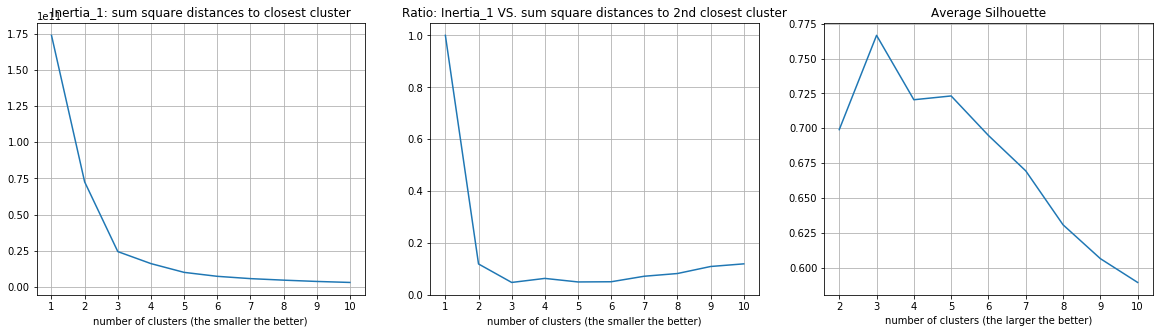

In [26]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters (the smaller the better)')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters (the smaller the better)')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters (the larger the better)')
plt.grid()

plt.show()

In this case the data was created to have  𝑘  clusters, but in practice this is of course unknown, and one of the user's tasks is to determine the appropriate value of  𝑘 .

In the first case (looking at inertias) what we are looking for is an "elbow" in the graph. In this case, it is located around  𝑘=3 . Notice that we do not choose the value of  𝑘  with the smallest value since the inertia keeps decreasing as  𝑘  increase. This is by construction of the quantity inertia.

When looking at the ration between inertia_1 and inertia_2, one looks for a minimum value, which in this case corresponds with  𝑘=3  as well.

The silhouette gives higher values for best clusterings, so what we look for is a maximum, which happens again at  𝑘=3.


In [0]:
#n_cluster should be equal to trueK
kmeans = KMeans(n_clusters=3, random_state=0).fit(df9) 

In [28]:
print(kmeans.cluster_centers_)

[[3.92941525e+00 2.89322273e+02 7.97089415e+02 8.67191743e+01
  4.21095485e+00 7.92800000e+03]
 [3.94477082e+00 3.16172056e+02 7.84470206e+02 1.07372319e+02
  4.96180290e+00 8.77261268e+02]
 [3.96209614e+00 3.26455323e+02 7.68267770e+03 3.51003940e+02
  6.04176517e+00 7.42189598e+03]]


In [29]:
print(kmeans.labels_)

[2 2 0 ... 1 1 1]


Add Label to the dataframe

In [30]:
df9['Kmean_Lable']=kmeans.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
df9.head()

,average_rating,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts,Kmean_Lable
0,4.41,352.0,6267.0,272.0,10,7928,2
1,4.40,240.0,11459.0,143.0,10,7928,2
2,4.55,480.0,3116.0,147.0,10,7928,0
3,4.22,215.0,4416.0,408.0,9,7928,2
4,3.98,6.0,56.0,14.0,9,7928,0


### Hierarchical Clustering


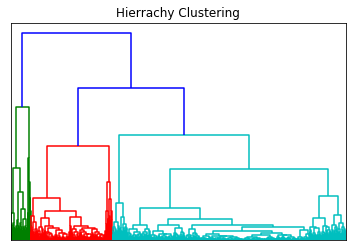

In [45]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(df9[['average_rating','# num_pages','ratings_count','text_reviews_count','authors_counts','language_code_counts']], 'complete')
dn = hierarchy.dendrogram(Z)
plt.xticks(())
plt.yticks(())
plt.title('Hierrachy Clustering')
plt.show()

# Classification

In [0]:
from sklearn.model_selection import train_test_split

X=df9[['average_rating','# num_pages','ratings_count','text_reviews_count','authors_counts','language_code_counts']]
y=df9['Kmean_Lable']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [0]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

min_max_scaler = preprocessing.MinMaxScaler()

rnd_clf = RandomForestClassifier(random_state=8)
svm_clf = SVC(random_state=8)
tree_clf = DecisionTreeClassifier(random_state=8)


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),random_state=8)
ada_clf.fit(X_train, y_train)



# voting_clf = VotingClassifier(
#     estimators=[('rf', rnd_clf), ('svc', svm_clf), ('dt',tree_clf), ('ada',ada_clf)],
#     voting='hard')

pca = PCA()

In [0]:
# Pipline for random forest

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

pipe_rnd = Pipeline(
    steps=[('scaler',min_max_scaler),
           ('pca', pca)
         , ('rf', rnd_clf)
    ]
)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_rnd = {
    'pca__n_components': [3,4,5],
    'rf__n_estimators': [50, 70, 100],
}

search_rnd = GridSearchCV(pipe_rnd, param_grid_rnd, iid=False, cv=5,
                      return_train_score=False)

# search_rnd.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search_rnd.best_score_)
# print(search_rnd.best_params_)

In [0]:
# Pipline for svm

pipe_svm = Pipeline(
    steps=[('scaler',min_max_scaler),
           ('pca', pca)
         , ('svm', svm_clf)
    ]
)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_svm = {
    'pca__n_components': [3,4,5],
    'svm__gamma': ["auto"],
}

search_svm = GridSearchCV(pipe_svm, param_grid_svm, iid=False, cv=5,
                      return_train_score=False)

# search_svm.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search_svm.best_score_)
# print(search_svm.best_params_)


In [0]:
# Pipline for decision tree

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

pipe_dt = Pipeline(
    steps=[('scaler',min_max_scaler),
           ('pca', pca)
         , ('dt', tree_clf)
    ]
)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_dt = {
    'pca__n_components': [3,4,5],
    'dt__max_depth': [10, 20, 50],
}

search_dt = GridSearchCV(pipe_dt, param_grid_dt, iid=False, cv=5,
                      return_train_score=False)

# search_dt.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search_dt.best_score_)
# print(search_dt.best_params_)

In [0]:
# Pipline for Ada Boost

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

pipe_ada = Pipeline(
    steps=[('scaler',min_max_scaler),
           ('pca', pca)
         , ('ada', ada_clf)
    ]
)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_ada = {
    'pca__n_components': [3,4,5],
    'ada__n_estimators': [10, 20, 50],
    'ada__algorithm': ["SAMME.R"],
    'ada__learning_rate':list(np.arange(0.1, 1, 0.1))
}

search_ada = GridSearchCV(pipe_ada, param_grid_ada, iid=False, cv=5,
                      return_train_score=False)

# search_ada.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search_ada.best_score_)
# print(search_ada.best_params_)

In [0]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# pipe_voting = Pipeline(
#     steps=[('scaler',min_max_scaler),
#            ('pca', pca)
#          , ('voting', voting_clf)
#     ]
# )

# # Parameters of pipelines can be set using ‘__’ separated parameter names:
# param_grid_voting = {
#     'pca__n_components': [3,4,5],
# #     'voting__n_estimators': [50, 70, 100],
# #     'voting__gamma': ["auto"],
# #     'voting__max_depth': [10, 20, 50],
# #     'voting__algorithm': ["SAMME.R"],
# #     'voting__learning_rate':list(np.arange(0.1, 1, 0.1))
# }

# search_voting = GridSearchCV(pipe_voting, param_grid_voting, iid=False, cv=5,
#                       return_train_score=False)

# # search_voting.fit(X_train, y_train)
# # print("Best parameter (CV score=%0.3f):" % search_voting.best_score_)
# # print(search_voting.best_params_)

In [40]:
from sklearn.metrics import accuracy_score

for clf in (search_rnd, search_svm, search_dt, search_ada):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Best parameter (CV score=%0.3f):" % clf.best_score_)
    print(clf.best_params_)
    print("train accuracy score:",clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train)))
    print("train f1 score:", clf.__class__.__name__, f1_score(y_train, clf.predict(X_train), average='micro'))
    print("test accuracy score:",clf.__class__.__name__, accuracy_score(y_test, y_pred))
    print("test f1 score:", clf.__class__.__name__, f1_score(y_test, y_pred, average='micro'))
    print("==================================================================")
    print("==================================================================")
    print("==================================================================")

Best parameter (CV score=0.987):
{'pca__n_components': 5, 'rf__n_estimators': 50}
train accuracy score: GridSearchCV 0.9998747024182433
train f1 score: GridSearchCV 0.9998747024182433
test accuracy score: GridSearchCV 0.9864712514092446
test f1 score: GridSearchCV 0.9864712514092446
Best parameter (CV score=0.972):
{'pca__n_components': 3, 'svm__gamma': 'auto'}
train accuracy score: GridSearchCV 0.9724345320135321
train f1 score: GridSearchCV 0.9724345320135321
test accuracy score: GridSearchCV 0.9748214956783164
test f1 score: GridSearchCV 0.9748214956783164
Best parameter (CV score=0.982):
{'dt__max_depth': 10, 'pca__n_components': 5}
train accuracy score: GridSearchCV 0.99924821450946
train f1 score: GridSearchCV 0.99924821450946
test accuracy score: GridSearchCV 0.9857196542653138
test f1 score: GridSearchCV 0.9857196542653138
Best parameter (CV score=0.977):
{'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 0.5, 'ada__n_estimators': 20, 'pca__n_components': 5}
train accuracy sco

The best models are decision tree or random *forest*

# Book Recommendation

In [41]:
# After classify the data, we need to give the recomment to each customer.
# We choose highest top ten books for each customers

df9.loc[df9.loc[:,'Kmean_Lable']==0,:].sort_values('average_rating',ascending=False).iloc[:10,:]

,average_rating,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts,Kmean_Lable
2113,4.67,32.0,2.0,533.632128,4,7928,0
6202,4.67,212.0,27.0,533.632128,3,7928,0
3102,4.67,216.0,1.0,533.632128,1,7928,0
1302,4.67,437.0,9.0,2.000000,1,7928,0
1348,4.67,32.0,3.0,533.632128,2,7928,0
1891,4.67,496.0,14.0,2.000000,1,7928,0
5402,4.67,158.0,6.0,1.000000,2,7928,0
5484,4.66,81.0,133.0,13.000000,1,7928,0
1467,4.66,266.0,2336.0,143.000000,2,7928,0
7046,4.64,124.0,8.0,533.632128,1,7928,0


In [42]:
df9.loc[df9.loc[:,'Kmean_Lable']==1,:].sort_values('average_rating',ascending=False).iloc[:10,:]

,average_rating,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts,Kmean_Lable
10163,4.64,256.0,250.0,13.000000,3,309,1
10404,4.62,160.0,23.0,2.000000,7,182,1
10400,4.61,152.0,55.0,3.000000,7,182,1
10403,4.61,223.0,24.0,4.000000,7,182,1
8770,4.60,3.0,76.0,7.000000,1,1449,1
10607,4.60,188.0,3.0,533.632128,8,14,1
10402,4.59,144.0,26.0,2.000000,7,182,1
9205,4.59,12.0,22.0,1.000000,5,1449,1
10606,4.58,191.0,5.0,533.632128,8,14,1
9275,4.58,296.0,176.0,9.000000,4,1449,1


In [43]:
df9.loc[df9.loc[:,'Kmean_Lable']==2,:].sort_values('average_rating',ascending=False).iloc[:10,:]

,average_rating,# num_pages,ratings_count,text_reviews_count,authors_counts,language_code_counts,Kmean_Lable
335,4.60,192.0,7159.0,111.0,9,7928,2
331,4.60,200.0,8273.0,137.0,9,7928,2
334,4.59,192.0,8313.0,109.0,9,7928,2
333,4.59,192.0,7335.0,120.0,9,7928,2
336,4.58,200.0,9618.0,185.0,9,7928,2
328,4.57,192.0,8568.0,141.0,9,7928,2
329,4.57,192.0,9621.0,145.0,9,7928,2
332,4.56,200.0,12344.0,188.0,9,7928,2
10035,4.55,419.0,10625.0,537.0,1,309,2
330,4.55,200.0,9920.0,270.0,9,7928,2
